In [ ]:
import pyedflib
import pandas as pd

Concatinating signals for training

Note for training only signals recorded during mental arithmetic will be used

In [50]:
import pyedflib
import numpy as np
import pandas as pd
import os

# Path to the EDF files and the CSV file
edf_folder_path = '/Users/ritwikghosh/Downloads/IIT Roorkee Project/eeg-during-mental-arithmetic-tasks-1.0.0/'
csv_file_path = os.path.join(edf_folder_path, 'subject-info.csv')

# Read the CSV file
subject_info = pd.read_csv(csv_file_path)

# Initialize the X matrix and y array
num_trials = 36
num_channels = 19
num_samples = 31000

X = np.zeros((num_trials, num_channels, num_samples))
y = np.zeros(num_trials)

# Process each subject and their trials
trial_index = 0
for i in range(1,36):
    subject_name = f'Subject{i:02d}'
    print(subject_name)
    label = subject_info[subject_info['Subject'] == subject_name]['Count quality'].values[0]
    
    for trial in range(2, 3):
        edf_file_name = f'{subject_name}_{trial}.edf'
        edf_file_path = os.path.join(edf_folder_path, edf_file_name)
        
        # Open the EDF file
        data = pyedflib.EdfReader(edf_file_path)
        
        # Read the signals data and convert to array
        signal_data = np.zeros((data.signals_in_file, data.getNSamples()[0]))
        for j in range(data.signals_in_file):
            signal_data[j, :] = data.readSignal(j)
        
        # Close the EDF file
        data.close()
        
        # Select only the first 19 channels and the first 91000 samples
        X[trial_index, :, :] = signal_data[:19, :num_samples]
        y[trial_index] = label
        
        trial_index += 1

# Verify the shape of X and y
print(X.shape)  # Should be (36, 19, 91000)
print(y.shape)  # Should be (36,)
print(y)        # Verify the labels


Subject01
Subject02
Subject03
Subject04
Subject05
Subject06
Subject07
Subject08
Subject09
Subject10
Subject11
Subject12
Subject13
Subject14
Subject15
Subject16
Subject17
Subject18
Subject19
Subject20
Subject21
Subject22
Subject23
Subject24
Subject25
Subject26
Subject27
Subject28
Subject29
Subject30
Subject31
Subject32
Subject33
Subject34
Subject35
(36, 19, 31000)
(36,)
[1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.]


In [3]:
y.sum() #data imbalance

26.0

In [15]:
pip install attention_models


DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.11/site-packages/pyeeg-0.4.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
ERROR: Could not find a version that satisfies the requirement attention_models (from versions: none)
ERROR: No matching distribution found for attention_models

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
!pwd

/Users/ritwikghosh


In [54]:
""" 
Copyright (C) 2022 King Saud University, Saudi Arabia 
SPDX-License-Identifier: Apache-2.0 

Licensed under the Apache License, Version 2.0 (the "License"); you may not use
this file except in compliance with the License. You may obtain a copy of the 
License at

http://www.apache.org/licenses/LICENSE-2.0  

Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR 
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the License. 

Author:  Hamdi Altaheri 
"""

#%%
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization, LayerNormalization, Flatten 
from tensorflow.keras.layers import Add, Concatenate, Lambda, Input, Permute
from tensorflow.keras.regularizers import L2
from tensorflow.keras.constraints import max_norm

from tensorflow.keras import backend as K

from attention_models import attention_block

#%% The proposed ATCNet model, https://doi.org/10.1109/TII.2022.3197419
def ATCNet_(n_classes=2, in_chans = 19, in_samples = 31000, n_windows = 5, attention = 'mha', 
           eegn_F1 = 16, eegn_D = 2, eegn_kernelSize = 64, eegn_poolSize = 7, eegn_dropout=0.3, 
           tcn_depth = 2, tcn_kernelSize = 4, tcn_filters = 32, tcn_dropout = 0.3, 
           tcn_activation = 'elu', fuse = 'average'):
    
    """ ATCNet model from Altaheri et al 2023.
        See details at https://ieeexplore.ieee.org/abstract/document/9852687
    
        Notes
        -----
        The initial values in this model are based on the values identified by
        the authors
        
        References
        ----------
        .. H. Altaheri, G. Muhammad, and M. Alsulaiman. "Physics-informed 
           attention temporal convolutional network for EEG-based motor imagery 
           classification." IEEE Transactions on Industrial Informatics, 
           vol. 19, no. 2, pp. 2249-2258, (2023) 
           https://doi.org/10.1109/TII.2022.3197419
    """
    input_1 = Input(shape = (1,in_chans, in_samples))   #     TensorShape([None, 1, 22, 1125])
    input_2 = Permute((3,2,1))(input_1) 

    dense_weightDecay = 0.5  
    conv_weightDecay = 0.009
    conv_maxNorm = 0.6
    from_logits = False

    numFilters = eegn_F1
    F2 = numFilters*eegn_D

    block1 = Conv_block_(input_layer = input_2, F1 = eegn_F1, D = eegn_D, 
                        kernLength = eegn_kernelSize, poolSize = eegn_poolSize,
                        weightDecay = conv_weightDecay, maxNorm = conv_maxNorm,
                        in_chans = in_chans, dropout = eegn_dropout)
    block1 = Lambda(lambda x: x[:,:,-1,:])(block1)
       
    # Sliding window 
    sw_concat = []   # to store concatenated or averaged sliding window outputs
    for i in range(n_windows):
        st = i
        end = block1.shape[1]-n_windows+i+1
        block2 = block1[:, st:end, :]
        
        # Attention_model
        if attention is not None:
            if (attention == 'se' or attention == 'cbam'):
                block2 = Permute((2, 1))(block2) # shape=(None, 32, 16)
                block2 = attention_block(block2, attention)
                block2 = Permute((2, 1))(block2) # shape=(None, 16, 32)
            else: block2 = attention_block(block2, attention)

        # Temporal convolutional network (TCN)
        block3 = TCN_block_(input_layer = block2, input_dimension = F2, depth = tcn_depth,
                            kernel_size = tcn_kernelSize, filters = tcn_filters, 
                            weightDecay = conv_weightDecay, maxNorm = conv_maxNorm,
                            dropout = tcn_dropout, activation = tcn_activation)
        # Get feature maps of the last sequence
        block3 = Lambda(lambda x: x[:,-1,:])(block3)
        
        # Outputs of sliding window: Average_after_dense or concatenate_then_dense
        if(fuse == 'average'):
            sw_concat.append(Dense(n_classes, kernel_regularizer=L2(dense_weightDecay))(block3))
        elif(fuse == 'concat'):
            if i == 0:
                sw_concat = block3
            else:
                sw_concat = Concatenate()([sw_concat, block3])
                
    if(fuse == 'average'):
        if len(sw_concat) > 1: # more than one window
            sw_concat = tf.keras.layers.Average()(sw_concat[:])
        else: # one window (# windows = 1)
            sw_concat = sw_concat[0]
    elif(fuse == 'concat'):
        sw_concat = Dense(n_classes, kernel_regularizer=L2(dense_weightDecay))(sw_concat)
               
    if from_logits:  # No activation here because we are using from_logits=True
        out = Activation('linear', name = 'linear')(sw_concat)
    else:   # Using softmax activation
        out = Activation('softmax', name = 'softmax')(sw_concat)
       
    return Model(inputs = input_1, outputs = out)

#%% Convolutional (CV) block used in the ATCNet model
def Conv_block(input_layer, F1=4, kernLength=64, poolSize=8, D=2, in_chans=19, dropout=0.1):
    """ Conv_block
    
        Notes
        -----
        This block is the same as EEGNet with SeparableConv2D replaced by Conv2D 
        The original code for this model is available at: https://github.com/vlawhern/arl-eegmodels
        See details at https://arxiv.org/abs/1611.08024
    """
    F2= F1*D
    block1 = Conv2D(F1, (kernLength, 1), padding = 'same',data_format='channels_last',use_bias = False)(input_layer)
    block1 = BatchNormalization(axis = -1)(block1)
    block2 = DepthwiseConv2D((1, in_chans), use_bias = False, 
                                    depth_multiplier = D,
                                    data_format='channels_last',
                                    depthwise_constraint = max_norm(1.))(block1)
    block2 = BatchNormalization(axis = -1)(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((8,1),data_format='channels_last')(block2)
    block2 = Dropout(dropout)(block2)
    block3 = Conv2D(F2, (16, 1),
                            data_format='channels_last',
                            use_bias = False, padding = 'same')(block2)
    block3 = BatchNormalization(axis = -1)(block3)
    block3 = Activation('elu')(block3)
    
    block3 = AveragePooling2D((poolSize,1),data_format='channels_last')(block3)
    block3 = Dropout(dropout)(block3)
    return block3

def Conv_block_(input_layer, F1=4, kernLength=64, poolSize=8, D=2, in_chans=19, 
                weightDecay = 0.009, maxNorm = 0.6, dropout=0.25):
    """ Conv_block
    
        Notes
        -----
        using  different regularization methods.
    """
    
    F2= F1*D
    block1 = Conv2D(F1, (kernLength, 1), padding = 'same', data_format='channels_last', 
                    kernel_regularizer=L2(weightDecay),
                    
                    # In a Conv2D layer with data_format="channels_last", the weight tensor has shape 
                    # (rows, cols, input_depth, output_depth), set axis to [0, 1, 2] to constrain 
                    # the weights of each filter tensor of size (rows, cols, input_depth).
                    kernel_constraint = max_norm(maxNorm, axis=[0,1,2]),
                    use_bias = False)(input_layer)
    block1 = BatchNormalization(axis = -1)(block1)  # bn_axis = -1 if data_format() == 'channels_last' else 1
    
    block2 = DepthwiseConv2D((1, in_chans),  
                             depth_multiplier = D,
                             data_format='channels_last',
                             depthwise_regularizer=L2(weightDecay),
                             depthwise_constraint  = max_norm(maxNorm, axis=[0,1,2]),
                             use_bias = False)(block1)
    block2 = BatchNormalization(axis = -1)(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((8,1),data_format='channels_last')(block2)
    block2 = Dropout(dropout)(block2)
    
    block3 = Conv2D(F2, (16, 1),
                            data_format='channels_last',
                            kernel_regularizer=L2(weightDecay),
                            kernel_constraint = max_norm(maxNorm, axis=[0,1,2]),
                            use_bias = False, padding = 'same')(block2)
    block3 = BatchNormalization(axis = -1)(block3)
    block3 = Activation('elu')(block3)
    
    block3 = AveragePooling2D((poolSize,1),data_format='channels_last')(block3)
    block3 = Dropout(dropout)(block3)
    return block3

#%% Temporal convolutional (TC) block used in the ATCNet model
def TCN_block(input_layer,input_dimension,depth,kernel_size,filters,dropout,activation='relu'):
    """ TCN_block from Bai et al 2018
        Temporal Convolutional Network (TCN)
        
        Notes
        -----
        THe original code available at https://github.com/locuslab/TCN/blob/master/TCN/tcn.py
        This implementation has a slight modification from the original code
        and it is taken from the code by Ingolfsson et al at https://github.com/iis-eth-zurich/eeg-tcnet
        See details at https://arxiv.org/abs/2006.00622

        References
        ----------
        .. Bai, S., Kolter, J. Z., & Koltun, V. (2018).
           An empirical evaluation of generic convolutional and recurrent networks
           for sequence modeling.
           arXiv preprint arXiv:1803.01271.
    """    
    
    block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=1,activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(input_layer)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=1,activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(block)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    if(input_dimension != filters):
        conv = Conv1D(filters,kernel_size=1,padding='same')(input_layer)
        added = Add()([block,conv])
    else:
        added = Add()([block,input_layer])
    out = Activation(activation)(added)
    
    for i in range(depth-1):
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(out)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(block)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        added = Add()([block, out])
        out = Activation(activation)(added)
        
    return out

def TCN_block_(input_layer,input_dimension,depth,kernel_size,filters, dropout,
               weightDecay = 0.009, maxNorm = 0.6, activation='relu'):
    """ TCN_block from Bai et al 2018
        Temporal Convolutional Network (TCN)
        
        Notes
        -----
        using different regularization methods
    """    
    
    block = Conv1D(filters, kernel_size=kernel_size, dilation_rate=1, activation='linear',
                    kernel_regularizer=L2(weightDecay),
                    kernel_constraint = max_norm(maxNorm, axis=[0,1]),
                    
                    padding = 'causal',kernel_initializer='he_uniform')(input_layer)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=1,activation='linear',
                    kernel_regularizer=L2(weightDecay),
                    kernel_constraint = max_norm(maxNorm, axis=[0,1]),

                    padding = 'causal',kernel_initializer='he_uniform')(block)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    if(input_dimension != filters):
        conv = Conv1D(filters,kernel_size=1,
                    kernel_regularizer=L2(weightDecay),
                    kernel_constraint = max_norm(maxNorm, axis=[0,1]),
                      
                    padding='same')(input_layer)
        added = Add()([block,conv])
    else:
        added = Add()([block,input_layer])
    out = Activation(activation)(added)
    
    for i in range(depth-1):
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                    kernel_regularizer=L2(weightDecay),
                    kernel_constraint = max_norm(maxNorm, axis=[0,1]),
                    
                   padding = 'causal',kernel_initializer='he_uniform')(out)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                    kernel_regularizer=L2(weightDecay),
                    kernel_constraint = max_norm(maxNorm, axis=[0,1]),

                    padding = 'causal',kernel_initializer='he_uniform')(block)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        added = Add()([block, out])
        out = Activation(activation)(added)
        
    return out

model = ATCNet_(n_classes=2, in_chans = 19, in_samples = 31000, n_windows = 5, attention = 'mha', 
           eegn_F1 = 16, eegn_D = 2, eegn_kernelSize = 64, eegn_poolSize = 7, eegn_dropout=0.3, 
           tcn_depth = 2, tcn_kernelSize = 4, tcn_filters = 32, tcn_dropout = 0.3, 
           tcn_activation = 'elu', fuse = 'average')

In [56]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1, 19,     │          0 │ -                 │
│ (InputLayer)        │ 31000)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_2 (Permute) │ (None, 31000, 19, │          0 │ input_layer_2[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 31000, 19, │      1,024 │ permute_2[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31000, 19, │         64 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_2  │ (None, 31000, 1,  │        608 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31000, 1,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_64       │ (None, 31000, 1,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_4 │ (None, 3875, 1,   │          0 │ activation_64[0]… │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_64          │ (None, 3875, 1,   │          0 │ average_pooling2… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 3875, 1,   │     16,384 │ dropout_64[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3875, 1,   │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_65       │ (None, 3875, 1,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_5 │ (None, 553, 1,    │          0 │ activation_65[0]… │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 553, 1,    │          0 │ average_pooling2… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, 553, 32)   │          0 │ dropout_65[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_10         │ (None, 549, 32)   │          0 │ lambda_12[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_11         │ (None, 549, 32)   │          0 │ lambda_12[0][0]   │
│ (GetItem)           │                   │            │                 

 Total params: 114,746 (448.23 KB)

 Trainable params: 113,306 (442.60 KB)

 Non-trainable params: 1,440 (5.62 KB)

# Reshaping data to desired input shape

In [57]:
X = X[:, np.newaxis,:, :]

In [58]:
X.shape

(36, 1, 19, 31000)

# Encoding Label Y as categorical_crossentropy loss takes labels in multiple columns

In [59]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

def encode_labels(y):
    # Convert y to integers
    y = np.round(y).astype('int')

    # Create a dictionary to map int labels to integer labels in ascending order
    label_dict = {label: i for i, label in enumerate(sorted(np.unique(y)))}

    # Map integer labels to integer labels in ascending order
    y_mapped = np.array([label_dict[label] for label in y]).reshape(-1, 1)

    # One-hot encode y
    onehot_encoder = OneHotEncoder()
    y_encoded = onehot_encoder.fit_transform(y_mapped)

    # Convert the one-hot encoded array into a DataFrame
    y_df = pd.DataFrame(y_encoded.toarray(), columns=[f'label_{i}' for i in range(y_encoded.shape[1])])

    return y_df

# Stratified Splitting due to imbalance

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=0, stratify=y_train)


y_train= encode_labels(y_train)
y_test= encode_labels(y_test)
y_val= encode_labels(y_val)


In [79]:
y_train.head()

,label_0,label_1
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0


In [61]:
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

In [62]:
fittedModel=model.fit(X_train, y_train, batch_size=64, epochs=5, verbose=2, 
                        validation_data=(X_val, y_val))

Epoch 1/5
1/1 - 21s - 21s/step - accuracy: 0.7200 - loss: 22.6374 - val_accuracy: 0.6667 - val_loss: 12.9751
Epoch 2/5
1/1 - 12s - 12s/step - accuracy: 0.6000 - loss: 13.0537 - val_accuracy: 0.6667 - val_loss: 12.8615
Epoch 3/5
1/1 - 12s - 12s/step - accuracy: 0.7600 - loss: 12.7936 - val_accuracy: 1.0000 - val_loss: 12.7633
Epoch 4/5
1/1 - 12s - 12s/step - accuracy: 0.7600 - loss: 12.6971 - val_accuracy: 1.0000 - val_loss: 12.6670
Epoch 5/5
1/1 - 10s - 10s/step - accuracy: 0.7200 - loss: 12.6380 - val_accuracy: 1.0000 - val_loss: 12.5775


In [63]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

y_pred_labels = (y_pred > 0.5).astype(int)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred_labels)

print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
Accuracy on the test set: 75.00%


In [68]:
model1=ATCNet_(n_classes=2, in_chans = 19, in_samples = 31000, n_windows = 5, attention = 'mha', 
           eegn_F1 = 16, eegn_D = 2, eegn_kernelSize = 64, eegn_poolSize = 7, eegn_dropout=0.3, 
           tcn_depth = 2, tcn_kernelSize = 4, tcn_filters = 32, tcn_dropout = 0.3, 
           tcn_activation = 'elu', fuse = 'average')

In [69]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['f1_score'])

In [80]:
# Model training for only 5 EPOCHS due its tendency to overfit as we have only 36 trails

In [70]:
fittedModel=model1.fit(X_train, y_train, batch_size=64, epochs=5, verbose=2, 
                        validation_data=(X_val, y_val))

Epoch 1/5
1/1 - 19s - 19s/step - f1_score: 0.5989 - loss: 22.3549 - val_f1_score: 0.2500 - val_loss: 12.7356
Epoch 2/5
1/1 - 10s - 10s/step - f1_score: 0.6362 - loss: 12.5988 - val_f1_score: 0.4000 - val_loss: 12.6334
Epoch 3/5
1/1 - 10s - 10s/step - f1_score: 0.5000 - loss: 12.4518 - val_f1_score: 0.4000 - val_loss: 12.5255
Epoch 4/5
1/1 - 10s - 10s/step - f1_score: 0.4048 - loss: 12.5285 - val_f1_score: 0.4000 - val_loss: 12.4197
Epoch 5/5
1/1 - 10s - 10s/step - f1_score: 0.4186 - loss: 12.3518 - val_f1_score: 0.4000 - val_loss: 12.3175


In [72]:
from sklearn.metrics import f1_score
y_pred = model1.predict(X_test)

y_pred_labels = (y_pred > 0.5).astype(int)

# Calculate the accuracy score
f1 = f1_score(y_test, y_pred_labels, average='weighted')

print(f"F1_score on the test set: {f1 * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
F1_score on the test set: 64.29%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
Best Threshold: 0.43
Best F1 Score: 75.40%


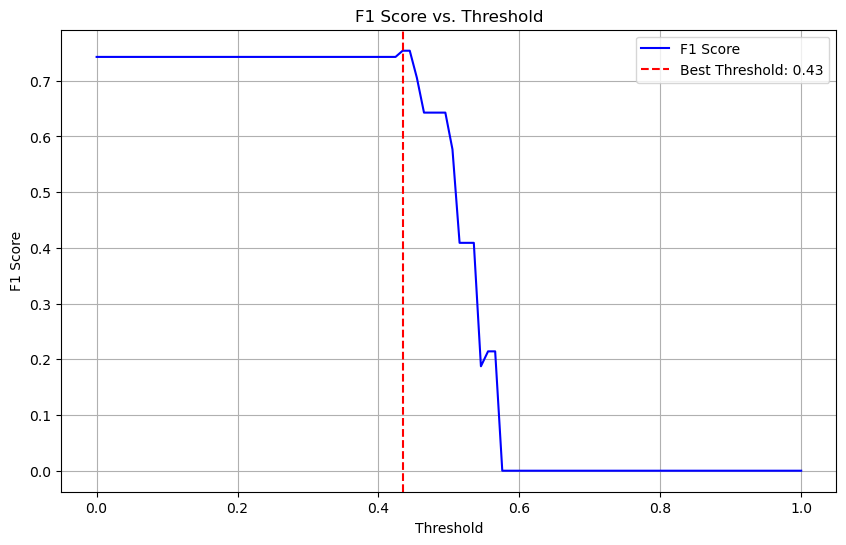

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Generate predictions
y_pred = model.predict(X_test)

# Initialize lists to store thresholds and corresponding F1 scores
thresholds = np.linspace(0, 1, 100)
f1_scores = []

# Variables to track the best threshold and F1 score
best_threshold = 0
best_f1_score = 0

# Calculate F1 score for each threshold
for threshold in thresholds:
    y_pred_labels = (y_pred > threshold).astype(int)
    f1 = f1_score(y_test, y_pred_labels, average='weighted')
    f1_scores.append(f1)
    
    # Update best threshold and F1 score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

# Print the best threshold and F1 score
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1_score * 100:.2f}%")

# Plot the F1 score against thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='b')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()
